In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_columns', None)

In [2]:
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for plotting
import matplotlib.pyplot as plt
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## for explainer
#from lime import lime_tabular

In [3]:
#to compute information gain
def compute_impurity(feature, impurity_criterion):
    """
    This function calculates impurity of a feature.
    Supported impurity criteria: 'entropy', 'gini'
    input: feature (this needs to be a Pandas series)
    output: feature impurity
    """
    probs = feature.value_counts(normalize=True)
    
    if impurity_criterion == 'entropy':
        impurity = -1 * np.sum(np.log2(probs) * probs)
    elif impurity_criterion == 'gini':
        impurity = 1 - np.sum(np.square(probs))
    else:
        raise ValueError('Unknown impurity criterion')
    return(round(impurity, 3))

def comp_feature_information_gain(df, target, descriptive_feature, split_criterion):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    and a given impurity criteria.
    Supported split criterion: 'entropy', 'gini'
    """
    
    print('target feature:', target)
    print('descriptive_feature:', descriptive_feature)
    print('split criterion:', split_criterion)
            
    target_entropy = compute_impurity(df[target], split_criterion)

    # we define two lists below:
    # entropy_list to store the entropy of each partition
    # weight_list to store the relative number of observations in each partition
    entropy_list = list()
    weight_list = list()
    
    # loop over each level of the descriptive feature
    # to partition the dataset with respect to that level
    # and compute the entropy and the weight of the level's partition
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        entropy_level = compute_impurity(df_feature_level[target], split_criterion)
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

   # print('impurity of partitions:', entropy_list)
   # print('weights of partitions:', weight_list)

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
    print('remaining impurity:', feature_remaining_impurity)
    
    information_gain = target_entropy - feature_remaining_impurity
    print('information gain:', information_gain)
    
    print('====================')

    return(information_gain)

In [4]:
#a = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
#b = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
a = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
b = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
c =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
d =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
e =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#c = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week3.csv', low_memory=False , encoding='cp1252')
#d = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week4.csv', low_memory=False, encoding='cp1252')
#e =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
#g =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
#h =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')

In [5]:
print(b.shape)
#a.drop(a[a['attackType'] == '---'].index, axis = 0, inplace= True) 
b.drop(b[b['attackType'] == '---'].index, axis = 0, inplace= True)  
c.drop(c[c['attackType'] == '---'].index, axis = 0, inplace= True)  
d.drop(d[d['attackType'] == '---'].index, axis = 0, inplace= True)  
#e.drop(e[e['attackType'] == '---'].index, axis = 0, inplace= True)  
b.shape

(10310733, 16)


(1795404, 16)

In [6]:
data_external = pd.concat([c,d,e], axis = 0)
data_external.reset_index(drop= True, inplace= True)

In [7]:
#to Increment attackID values
data_external['attackID'] = data_external['attackID'].apply(lambda x: str(int(x) + 70) if x != '---' else x)

In [8]:
def convert_bytes(df):
    if 'M' in df:
        df = df.split('M')
        df = df[0].strip()
        df = float(df) * 1000000
    elif 'B' in df:
        df = df.split('B')
        df = df[0].strip()
        df =  float(df) * 1000000000
    else: 
        df =float(df)
    return df

In [9]:
data = pd.concat([a,b,data_external], axis = 0)
data.reset_index(drop= True, inplace= True)
data['Bytes'] = data['Bytes'].apply(lambda x: convert_bytes(x))
data['attackType'] = data['attackType'].apply(lambda x:  'attack' if (x!= '---') else x )

columns = ['Src Pt', 'Dst Pt','Tos','Flows','Packets', 'Bytes']
for i in columns:
    data[i] = pd.to_numeric(data[i]);
del columns
del a,b,c,d,e, data_external
gc.collect()

60

In [10]:
#Converts Hexadecimal value to Binary
def hex_to_binary(hexdata):
    scale = 16 ## equals to hexadecimal
    num_of_bits = 9
    return bin(int(hexdata, scale))[2:].zfill(num_of_bits);
#Converts TCP flags to Binary
def to_Binary(x):
    l = 0
    x = '...' + x
    x = list(x)
    for i in x:
        if (i=='.'):
            x[l]= '0'
        else:
            x[l] = '1'
        l = l +1
    return ''.join(x)
#Converts the 'Flags' column to 9 indiviual columns (manual oneshot encoding)
def flag_convert(df):  
   # df['Flags'] = df['Flags'].apply(lambda x: (list(x)))
   # temp = df['Flags'].apply(lambda x: toBinary(x))
    hex_values = list(df[(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    flag_values = list(df[~(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    binary_values = {}
    for i in hex_values:
         binary_values[i] = (hex_to_binary(i))
    for i in flag_values:
         binary_values[i] = (to_Binary(i))
    temp = df['Flags'].replace(binary_values)
#temp = temp.apply(lambda x: pd.Series(x)) 
    temp = pd.DataFrame(temp.apply(list).tolist())
#temp = pd.DataFrame(temp)
#a = a.iloc[: , 1:]
   # print(temp.head())
    temp.columns = ['N','C','E','U' ,'A','P','R','S','F']
    for i in temp.columns:
        temp[i] = pd.to_numeric(temp[i]);
    temp = temp.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp], axis = 1)
    return df;

In [11]:
#make a IP_pairs 
def make_pair(df):
    ip_pair = df['Src IP Addr'] +'/' +df['Dst IP Addr']
    source_ip = df['Src IP Addr'].unique().tolist()
    destination_ip = df['Dst IP Addr'].unique().tolist()
   # df = df.drop(columns = ['Src IP Addr', 'Dst IP Addr'])
    df.insert(1, ' IP Pair', ip_pair)
    return df

def check_inverse(df):
    list_pairs = df[' IP Pair'].unique()
    tuple_pair = []
    for i in list_pairs:
        tuple_pair.append(tuple((i.split('/'))))
    dic_store = {}
    for i in tuple_pair:
        if (i  not in dic_store.keys()) and (i[::-1] not in dic_store.keys()):
            dic_store[i] = i[0] + '/' +i[1]
    print(len(dic_store.keys()))
    dic_final = {}
    for i in dic_store.keys():
        dic_final[i[0] + '/' +i[1]] = dic_store[i]
        dic_final[i[1] + '/' +i[0]] = dic_store[i]
    df[' IP Pair'] = df[' IP Pair'].map(dic_final)               
    return df

In [12]:
def normalize_IP(df):
    columns = ['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1',
              'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [13]:
def normalize(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    columns = data.select_dtypes(include=numerics).columns
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [14]:
def one_shot(df):
    label_encoder = LabelEncoder()
    #df.astype({'attackType': 'str'})
    df['attackType'] = label_encoder.fit_transform(df['attackType'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    

    
    df['Proto'] = label_encoder.fit_transform(df['Proto'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    onehot_encoder1 = OneHotEncoder()
    onehot_encoder1.fit(df.Proto.to_numpy().reshape(-1, 1))
    proto = onehot_encoder1.transform(df.Proto.to_numpy().reshape(-1, 1))
    proto = pd.DataFrame.sparse.from_spmatrix(proto)
    proto.astype('int32')
    proto.columns = label_encoder.classes_
   # print(proto.head(1))
    df = pd.concat([df, proto], axis = 1)
    return df;

In [15]:
def drop_columns(df):
    return df.drop(columns = ['Date first seen', ' IP Pair', 'Flows', 'class', 'attackID','Flags',
                              'attackDescription', 'Src IP Addr', 'Dst IP Addr','Proto'], axis =1)

In [16]:
#Aplit IP address into features, 7 features
def split_to_net(IP_address):
    IP_list = IP_address.split(".")
    needed_len = 7
    needed_len = needed_len - len(IP_list)
    for i in range(0,needed_len,1):
        IP_list.append('0')
    return IP_list
#replace unknown IP address, and convert to columns
def IP_split(df): 
    replace = {"ATTACKER1":"0.0.0.0",
           "ATTACKER2":"0.0.0.0",
           "ATTACKER3":"0.0.0.0",
           "EXT_SERVER": "0.0.0.0.1",
          "OPENSTACK_NET": "0.0.0.0.0.1",
          "DNS": "0.0.0.0.0.0.1"}
    df = df.replace({"Src IP Addr": replace, "Dst IP Addr": replace}, value=None)
    temp_source = df["Src IP Addr"].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
    temp_des = df['Dst IP Addr'].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
   # sourceIP = list(df["Src IP Addr"].unique())
   # destIP = list(df["Dst IP Addr"].unique())
   # sourceIP_values = {}
   # desIP_values = {}
   # for i in sourceIP:
   #      sourceIP_values[i] = (split_to_net(i))
   # for i in destIP:
   #      desIP_values[i] = (split_to_net(i))
    #print(sourceIP_values)
   # print(desIP_values)
#for Source IP
    temp_source = temp_source.apply(lambda x: split_to_net(x) )
    temp_source = pd.DataFrame(temp_source.apply(list).tolist())
    temp_source.columns = ['sourceIP_feature 1','sourceIP_feature 2','sourceIP_feature 3','sourceIP_feature 4' ,
                    'sourceEXT_SERVER','sourceOPENSTACK_NET','sourceDNS']
    for i in temp_source.columns:
        temp_source[i] = pd.to_numeric(temp_source[i]);
    temp_source = temp_source.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_source], axis = 1)
    #for Destination IP
    temp_des = temp_des.apply(lambda x: split_to_net(x) )
    temp_des = pd.DataFrame(temp_des.apply(list).tolist())
    temp_des.columns = ['destIP_feature 1','destIP_feature 2','destIP_feature 3','destIP_feature 4' ,
                    'destEXT_SERVER','destOPENSTACK_NET','destDNS']
    for i in temp_des.columns:
        temp_des[i] = pd.to_numeric(temp_des[i]);
    temp_des = temp_des.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_des], axis = 1)
    return df;

In [17]:
data = make_pair(data)
data = check_inverse(data)

59362


In [18]:
#data = IP_split(data)

In [19]:
data = normalize(data)
data =  one_shot(data) 
#data = normalize_IP(data)

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos'], dtype='object')
['---', 'attack']
[0, 1]
['GRE  ', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']
[0, 1, 2, 3, 4]


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [20]:
data_ig = flag_convert(data)
data_ig = drop_columns(data)

In [21]:
split_criterion = 'entropy'
feature_info_gain = {}
for feature in data_ig.drop(columns='attackType').columns:
    feature_info_gain[feature] = comp_feature_information_gain(data_ig, 'attackType', feature, split_criterion)
feature_info_gain

target feature: attackType
descriptive_feature: Duration
split criterion: entropy
remaining impurity: 0.401493
information gain: 0.640507
target feature: attackType
descriptive_feature: Src Pt
split criterion: entropy
remaining impurity: 0.27205699999999994
information gain: 0.769943
target feature: attackType
descriptive_feature: Dst Pt
split criterion: entropy
remaining impurity: 0.27464799999999995
information gain: 0.767352
target feature: attackType
descriptive_feature: Packets
split criterion: entropy
remaining impurity: 0.48312599999999994
information gain: 0.5588740000000001
target feature: attackType
descriptive_feature: Bytes
split criterion: entropy
remaining impurity: 0.065486
information gain: 0.976514
target feature: attackType
descriptive_feature: Tos
split criterion: entropy
remaining impurity: 0.8962410000000001
information gain: 0.14575899999999997
target feature: attackType
descriptive_feature: GRE  
split criterion: entropy


C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


remaining impurity: 1.042
information gain: 0.0
target feature: attackType
descriptive_feature: ICMP 
split criterion: entropy
remaining impurity: 1.032648
information gain: 0.009352000000000027
target feature: attackType
descriptive_feature: IGMP 
split criterion: entropy
remaining impurity: 1.042
information gain: 0.0
target feature: attackType
descriptive_feature: TCP  
split criterion: entropy
remaining impurity: 0.9856520000000001
information gain: 0.056347999999999954
target feature: attackType
descriptive_feature: UDP  
split criterion: entropy
remaining impurity: 0.9867680000000001
information gain: 0.05523199999999995


{'Duration': 0.640507,
 'Src Pt': 0.769943,
 'Dst Pt': 0.767352,
 'Packets': 0.5588740000000001,
 'Bytes': 0.976514,
 'Tos': 0.14575899999999997,
 'GRE  ': 0.0,
 'ICMP ': 0.009352000000000027,
 'IGMP ': 0.0,
 'TCP  ': 0.056347999999999954,
 'UDP  ': 0.05523199999999995}

In [22]:
feature_info_gain = pd.DataFrame.from_dict([feature_info_gain]).transpose()
feature_info_gain = pd.DataFrame(feature_info_gain[0].sort_values(ascending = False))
feature_info_gain.columns = ['entropy']
feature_info_gain

,entropy
Bytes,0.976514
Src Pt,0.769943
Dst Pt,0.767352
Duration,0.640507
Packets,0.558874
Tos,0.145759
TCP,0.056348
UDP,0.055232
ICMP,0.009352
IGMP,0.000000


In [25]:
split_criterion = 'gini'
feature_info_gain1 = {}
for feature in data_ig.drop(columns='attackType').columns:
    feature_info_gain1[feature] = comp_feature_information_gain(data_ig, 'attackType', feature, split_criterion)
feature_info_gain1

target feature: attackType
descriptive_feature: Duration
split criterion: gini
remaining impurity: 0.14406099999999997
information gain: 0.30093900000000007
target feature: attackType
descriptive_feature: Src Pt
split criterion: gini
remaining impurity: 0.133217
information gain: 0.31178300000000003
target feature: attackType
descriptive_feature: Dst Pt
split criterion: gini
remaining impurity: 0.13347900000000001
information gain: 0.311521
target feature: attackType
descriptive_feature: Packets
split criterion: gini
remaining impurity: 0.202782
information gain: 0.24221800000000002
target feature: attackType
descriptive_feature: Bytes
split criterion: gini
remaining impurity: 0.024279000000000002
information gain: 0.420721
target feature: attackType
descriptive_feature: Tos
split criterion: gini
remaining impurity: 0.392797
information gain: 0.052203
target feature: attackType
descriptive_feature: GRE  
split criterion: gini
remaining impurity: 0.445
information gain: 0.0
target featu

{'Duration': 0.30093900000000007,
 'Src Pt': 0.31178300000000003,
 'Dst Pt': 0.311521,
 'Packets': 0.24221800000000002,
 'Bytes': 0.420721,
 'Tos': 0.052203,
 'GRE  ': 0.0,
 'ICMP ': 0.0007480000000000264,
 'IGMP ': 0.0,
 'TCP  ': 0.018392999999999993,
 'UDP  ': 0.019359000000000015}

In [26]:
feature_info_gain1 = pd.DataFrame.from_dict([feature_info_gain1]).transpose()
feature_info_gain1 = pd.DataFrame(feature_info_gain1[0].sort_values(ascending = False), column = ['gini'])
#feature_info_gain1.columns = ['gini']
feature_info_gain1

TypeError: __init__() got an unexpected keyword argument 'column'

In [27]:
#The FIrst 9 features are selected
selected_features = feature_info_gain.index
selected_features = selected_features[0:9]
selected_features

Index(['Bytes', 'Src Pt', 'Dst Pt', 'Duration', 'Packets', 'Tos', 'TCP  ',
       'UDP  ', 'ICMP '],
      dtype='object')

In [20]:
gc.collect()

20

In [21]:
from datetime import datetime
def unix_time(df):
  #  df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x + ':00' if len(x) != 19 else x)
   # df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x[0 : 5 : ] + x[7 : :] if len(x) != 19 else x[0 : 7 : ] + x[9 : :])
    df['Date first seen'] = df['Date first seen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
    df['Date first seen'] = df['Date first seen'].apply(lambda x: x.timestamp()*1000)
    return df;

In [22]:
def normal_profile(grouped):
    grouped['---'] = unix_time(grouped['---'])
    start_time = int(grouped['---'].head(1)['Date first seen'].values[0])
    end_time = int(grouped['---'].tail(1)['Date first seen'].values[0])
#date_bins = pd.IntervalIndex.from_tuples(
#        [(i, i+3600000) for i in range(start_time, end_time, 3600000)],
#        closed="left")
#date_labels = [f"{i}" for i in range(1, len(date_bins)+1, 1)]
    normal_data = dict(tuple( grouped['---'].groupby( pd.cut(
            grouped['---']['Date first seen'],
               np.arange(start_time, end_time, 3*3600000)))))
    del grouped['---']
    num = []
    for i in grouped_data.keys():
          num.append(len(grouped_data[i]))
    print(min(num))
    num = max(num)
    print(num)
    print(len(grouped.keys()))
    grouped = {**grouped, **normal_data}
    print(len(grouped.keys()))
    return grouped, num;

In [23]:
grouped_data= dict(tuple(data.groupby(['attackID'])))
del data
gc.collect()

0

In [24]:
no_1 = []
no_2 = []
no_3 = []
no_4 = []
for i in grouped_data.keys():
   
    if grouped_data[i]['attackType'].unique()[0] == 0:
        print(f"{i}: {len(grouped_data[i])} : {grouped_data[i]['attackType'].unique()[0]}")
    if grouped_data[i]['attackType'].unique()[0] == 1:
              no_1.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 2:
              no_2.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 3:
              no_3.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 4:
              no_4.append(i)
for i in no_1:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"dos : {len(no_2)}")
for i in no_2:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"pingScan: {len(no_3)}")
for i in no_3:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"portScan : {len(no_4)}")
for i in no_4:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")


---: 7195669 : 0
Attack ID: 1; Lenght of Attack: 7657; Attack Type: 1
Attack ID: 10; Lenght of Attack: 311; Attack Type: 1
Attack ID: 11; Lenght of Attack: 17401; Attack Type: 1
Attack ID: 12; Lenght of Attack: 11526; Attack Type: 1
Attack ID: 13; Lenght of Attack: 513; Attack Type: 1
Attack ID: 14; Lenght of Attack: 13807; Attack Type: 1
Attack ID: 15; Lenght of Attack: 64; Attack Type: 1
Attack ID: 16; Lenght of Attack: 261003; Attack Type: 1
Attack ID: 17; Lenght of Attack: 13338; Attack Type: 1
Attack ID: 18; Lenght of Attack: 295302; Attack Type: 1
Attack ID: 19; Lenght of Attack: 11672; Attack Type: 1
Attack ID: 2; Lenght of Attack: 1927; Attack Type: 1
Attack ID: 20; Lenght of Attack: 11748; Attack Type: 1
Attack ID: 21; Lenght of Attack: 5113; Attack Type: 1
Attack ID: 22; Lenght of Attack: 295; Attack Type: 1
Attack ID: 23; Lenght of Attack: 72788; Attack Type: 1
Attack ID: 24; Lenght of Attack: 466; Attack Type: 1
Attack ID: 25; Lenght of Attack: 201; Attack Type: 1
Attack ID

In [25]:
del no_1
del no_2
del no_3
del no_4
gc.collect()

20

In [26]:
def del_largeInstances(dic, length):
    remove_ID = []
    for i in dic.keys():
        if (i != '---'):
            if(len(dic[i]) >= length):
                remove_ID.append(i)
    print(len(remove_ID))
    removed_attacks = {}
    for i in remove_ID:
        removed_attacks[i] = dic[i]
        del dic[i]
    return dic;

In [27]:
grouped_data = del_largeInstances(grouped_data, 20000)

19


In [28]:
for i in grouped_data.keys():
    grouped_data[i] = flag_convert(grouped_data[i])
grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
   # grouped_data[i] = flag_convert(grouped_data[i])
    grouped_data[i] =  drop_columns(grouped_data[i])

40
19732
73
350


In [29]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491598876632, 1491609676632] : False
(1491609676632, 1491620476632] : False
(1491620476632, 1491631276632] : False
(1491631276632, 1491642076632] : False
(1491642076632, 1491652876632] : False
(1491652876632, 1491663676632] : False
(1491663676632, 1491674476632] : False
(1491674476632, 1491685276632] : False
(1491685276632, 1491696076632] : False
(1491696076632, 1491706876632] : False
(1491706876632, 1491717676632] : False
(1491717676632, 1491728476632] : False
(1491728476632, 1491739276632] : False
(1491739276632, 1491750076632] : False
(1491750076632, 1491760876632] : False
(1491760876632, 1491771676632] : False
(1491771676632, 1491782476632] : False
(1491782476632, 1491793276632] : False
(1491793276632, 1491804076632] : False
(1491804076632, 1491814876632] : False
(1491814876632, 1491825676632] : False
(1491825676632, 1491836476632] : False
(1491836476632, 1491847276632] : False
(1491847276632, 1491858076632] : False
(1491858076632, 1491868876632] : False
(1491868876632, 149187967

In [30]:
counter = 0
for i in grouped_data.keys():
    if ( len(grouped_data[i]) == 0):
        counter = counter +1;
print(f"Number of Instances which are empty: {counter}")

Number of Instances which are empty: 167


In [31]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
#Convert to 3D arrays, input dict
def make_array(dic):
    x = []
    y = []
    zero_arrays = []
    for i in dic.keys():
        if ( len(dic[i]) == 0):
            zero_arrays.append(i);
    for i in zero_arrays:
        del dic[i]
    for i in dic.keys():
        x.append(np.array(dic[i].drop(['attackType'],axis = 1)).astype(np.float32))
       # print(f'{i}')
        y.append(dic[i]['attackType'].values[0])
    print(len(y))
    o = []
    features = len(x[1][1])
    #for i in x:
     #   o.append(len(i))
   # print(min(o))
    o = num
    o = roundup(o)
    print(o)
    index = 0
    for i in x:
        l = len(i)
        i = list(i)
        if(o > l):
            l = o-l
            for j in range(0, l, 1):
                i.append([0] * features)
        elif (o<l):
            l = l-o
            i = i[:-l]
        #i = [k = np.array([k]) for l in i for k in l] # Makes array elements an array 
        x[index] = np.array(i).astype(np.float32)
        index = index + 1
    #x = [[i] for i in x]
    return x,y

In [32]:
#Remove columns that were not listed in cfs list
selected_features = ['Bytes', 'Src Pt', 'Dst Pt', 'Duration', 'Packets', 'Tos', 'TCP  ',
       'UDP  ', 'ICMP ', 'attackType']
for i in grouped_data.keys():
    if ( len(grouped_data[i]) != 0):
        grouped_data[i] = grouped_data[i][selected_features]

In [33]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491631276632, 1491642076632] : False
(1491642076632, 1491652876632] : False
(1491652876632, 1491663676632] : False
(1491663676632, 1491674476632] : False
(1491674476632, 1491685276632] : False
(1491685276632, 1491696076632] : False
(1491696076632, 1491706876632] : False
(1491706876632, 1491717676632] : False
(1491717676632, 1491728476632] : False
(1491728476632, 1491739276632] : False
(1491739276632, 1491750076632] : False
(1491750076632, 1491760876632] : False
(1491760876632, 1491771676632] : False
(1491771676632, 1491782476632] : False
(1491782476632, 1491793276632] : False
(1491793276632, 1491804076632] : False
(1491804076632, 1491814876632] : False
(1491814876632, 1491825676632] : False
(1491825676632, 1491836476632] : False
(1491836476632, 1491847276632] : False
(1491847276632, 1491858076632] : False
(1491858076632, 1491868876632] : False
(1491868876632, 1491879676632] : False
(1491879676632, 1491890476632] : False
(1491890476632, 1491901276632] : False
(1491901276632, 149191207

In [34]:
X,Y = make_array(grouped_data)
del grouped_data
gc.collect()
Y = np.array(Y)
X = np.array(X)

183
19800


In [35]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 110, 1: 73}

In [36]:
def make_4D(arr):
    x = []
    for i in range(0, len(arr),1):
        temp = []
        for j in range(0,len(arr[i]),1):
             temp.append([np.array([k]) for k in arr[i][j]])
        x.append(np.array(temp).astype(np.float32))
    return np.array(x).astype(np.float32)

In [37]:
#X = make_4D(X)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=0,  stratify=Y)

In [39]:
del X,Y
gc.collect()

100

In [40]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 88, 1: 58}

In [41]:
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 22, 1: 15}

In [42]:
for i in X_train:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [43]:
nsamples,nx, ny = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny} \n " )

samples: 146 
 X:19800 
 Y:9 
 


In [44]:
X_train = X_train.reshape((nsamples,nx*ny))
X_test = X_test.reshape((37,nx*ny))

In [45]:
search_space = {
    "criterion": ("gini", "entropy"),
    "max_leaf_nodes": (2, 10, None),
    "max_depth": (1, nx*ny),
    "min_samples_split": (2, int(nsamples/4)),
    "min_samples_leaf": (1,int(nsamples/4) ),
    "min_weight_fraction_leaf": (0.01, 0.5),
    "max_features": ("auto", "sqrt","log2", None),
    "random_state": (0,42)
}

In [46]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta
cv = StratifiedKFold(n_splits=7, shuffle=True)

In [47]:
estimator = DecisionTreeClassifier()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

In [48]:
def print_status(optimal_result):
    """Shows the best parameters found and accuracy attained of the search so far."""
    models_tested = pd.DataFrame(bayes_cv_tuner.cv_results_)
    best_parameters_so_far = pd.Series(bayes_cv_tuner.best_params_)
    print(
        "Model #{}\nBest accuracy so far: {}\nBest parameters so far: {}\n".format(
            len(models_tested),
            np.round(bayes_cv_tuner.best_score_, 3),
            bayes_cv_tuner.best_params_,
        )
    )

In [60]:
result_dtc = bayes_cv_tuner.fit(X_train, Y_train, callback=[print_status, DeltaXStopper(0.0001)])

Model #1
Best accuracy so far: 0.863
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 148334), ('max_features', 'auto'), ('max_leaf_nodes', 10), ('min_samples_leaf', 12), ('min_samples_split', 15), ('min_weight_fraction_leaf', 0.1399687756713662), ('random_state', 7)])

Model #2
Best accuracy so far: 0.863
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 148334), ('max_features', 'auto'), ('max_leaf_nodes', 10), ('min_samples_leaf', 12), ('min_samples_split', 15), ('min_weight_fraction_leaf', 0.1399687756713662), ('random_state', 7)])

Model #3
Best accuracy so far: 0.863
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('max_depth', 148334), ('max_features', 'auto'), ('max_leaf_nodes', 10), ('min_samples_leaf', 12), ('min_samples_split', 15), ('min_weight_fraction_leaf', 0.1399687756713662), ('random_state', 7)])

Model #4
Best accuracy so far: 0.863
Best parameters so far: OrderedDict([('criterion', 'entropy'), ('m

Model #29
Best accuracy so far: 0.884
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max_depth', 34701), ('max_features', 'auto'), ('max_leaf_nodes', None), ('min_samples_leaf', 14), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.05699502398527299), ('random_state', 42)])

Model #30
Best accuracy so far: 0.884
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max_depth', 34701), ('max_features', 'auto'), ('max_leaf_nodes', None), ('min_samples_leaf', 14), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.05699502398527299), ('random_state', 42)])

Model #31
Best accuracy so far: 0.884
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max_depth', 34701), ('max_features', 'auto'), ('max_leaf_nodes', None), ('min_samples_leaf', 14), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.05699502398527299), ('random_state', 42)])

Model #32
Best accuracy so far: 0.884
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #41
Best accuracy so far: 0.932
Best parameters so far: OrderedDict([('criterion', 'gini'), ('max_depth', 178200), ('max_features', 'auto'), ('max_leaf_nodes', None), ('min_samples_leaf', 1), ('min_samples_split', 29), ('min_weight_fraction_leaf', 0.01), ('random_state', 3)])



In [61]:
model_dtc = DecisionTreeClassifier(
    criterion = result_dtc.best_params_['criterion'],
     max_leaf_nodes =  result_dtc.best_params_['max_leaf_nodes'],
       max_depth = result_dtc.best_params_['max_depth'],
    min_samples_split = result_dtc.best_params_['min_samples_split'],
    min_samples_leaf = result_dtc.best_params_['min_samples_leaf'],
    min_weight_fraction_leaf = result_dtc.best_params_['min_weight_fraction_leaf'],
    max_features = result_dtc.best_params_['max_features'],
    random_state = result_dtc.best_params_['random_state'],


    )

In [62]:
model_dtc.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=178200,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=29,
                       min_weight_fraction_leaf=0.01, presort=False,
                       random_state=3, splitter='best')

In [63]:
# predict probabilities for test set
yhat_probs = model_dtc.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [65]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.945946
Precision: 0.958333
Recall: 0.933333
F1 score: 0.942547


In [66]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.885449
[[22  0]
 [ 2 13]]


In [67]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


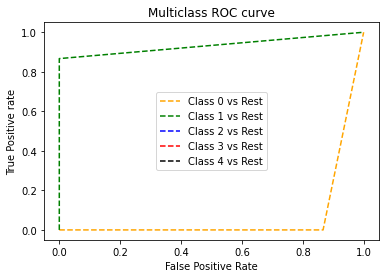

In [68]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [69]:
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 2 13]]


In [70]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.87      0.93        15

    accuracy                           0.95        37
   macro avg       0.96      0.93      0.94        37
weighted avg       0.95      0.95      0.95        37



In [71]:
import pickle
filename = './models/IG feature selection/WithoutIP Top9/Binary/DT/DT.sav'
pickle.dump(model_dtc, open(filename, 'wb'))
gc.collect()

4195

In [72]:
from skopt.space import Real, Categorical, Integer
search_space = {
    "C": Real(1e-6, 1e+6, prior='log-uniform'),
    "gamma": Real(1e-6, 1e+1, prior='log-uniform'),
    "kernel": Categorical(['linear', 'rbf']),
}

In [73]:
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

scorers = {
 #   'precision_score': make_scorer(precision_score),
#    'recall_score': make_scorer(recall_score),
#    'accuracy_score': make_scorer(accuracy_score),
    'f1_score':make_scorer(f1_score)
}
estimator = svm.SVC()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

In [74]:
result_svm = bayes_cv_tuner.fit(X_train, Y_train, callback= [DeltaXStopper(0.0001), 
                                     print_status])


Model #1
Best accuracy so far: 0.952
Best parameters so far: OrderedDict([('C', 87452.4884097983), ('gamma', 0.00418190739977607), ('kernel', 'linear')])

Model #2
Best accuracy so far: 0.952
Best parameters so far: OrderedDict([('C', 87452.4884097983), ('gamma', 0.00418190739977607), ('kernel', 'linear')])

Model #3
Best accuracy so far: 0.952
Best parameters so far: OrderedDict([('C', 87452.4884097983), ('gamma', 0.00418190739977607), ('kernel', 'linear')])

Model #4
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('C', 21.537219115827895), ('gamma', 0.5969217843656571), ('kernel', 'linear')])

Model #5
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('C', 21.537219115827895), ('gamma', 0.5969217843656571), ('kernel', 'linear')])

Model #6
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('C', 21.537219115827895), ('gamma', 0.5969217843656571), ('kernel', 'linear')])

Model #7
Best accuracy so far: 0.959
Best parameters so far: Ordere

In [75]:
#Create a svm Classifier
clf = svm.SVC(kernel= result_svm.best_params_['kernel'], C = result_svm.best_params_['C'], gamma = result_svm.best_params_['gamma'])

#Train the model using the training sets
clf.fit(X_train, Y_train)

SVC(C=0.026578553456083332, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0011985425793238514,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [76]:
# predict probabilities for test set
yhat_probs = clf.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [77]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [78]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.918919
Precision: 0.920807
Recall: 0.910606
F1 score: 0.914943


In [79]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.830015
[[21  1]
 [ 2 13]]


In [80]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


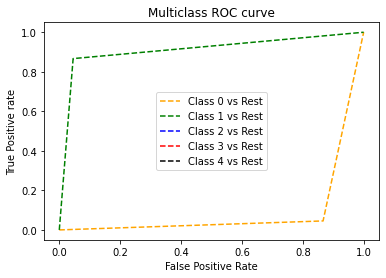

In [81]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [82]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[21  1]
 [ 2 13]]


In [83]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.93      0.87      0.90        15

    accuracy                           0.92        37
   macro avg       0.92      0.91      0.91        37
weighted avg       0.92      0.92      0.92        37



In [84]:
import pickle
filename = './models/IG feature selection/WithoutIP Top9/Binary/SVM/SVM.sav'
pickle.dump(clf, open(filename, 'wb'))
gc.collect()

4361

In [85]:
search_space = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

In [86]:
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

In [87]:
result_knn = bayes_cv_tuner.fit(X_train, Y_train, callback= [DeltaXStopper(0.0001), 
                                     print_status])


Model #1
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 13), ('weights', 'distance')])

Model #2
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 13), ('weights', 'distance')])

Model #3
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 13), ('weights', 'distance')])

Model #4
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 13), ('weights', 'distance')])

Model #5
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 13), ('weights', 'distance')])

Model #6
Best accuracy so far: 0.89
Best parameters so far: OrderedDict([('metric', 'minkowski'), ('n_neighbors', 13), ('weights', 'distance')])

Model #7
Best accuracy so far: 0.904
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 11), ('we

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #17
Best accuracy so far: 0.925
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #18
Best accuracy so far: 0.925
Best parameters so far: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 9), ('weights', 'distance')])



In [88]:
model_KNN = KNeighborsClassifier(
    n_neighbors = result_knn.best_params_['n_neighbors'],
     weights =  result_knn.best_params_['weights'],
       metric = result_knn.best_params_['metric']
    )

In [89]:
model_KNN.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [90]:
# predict probabilities for test set
yhat_probs = model_KNN.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [91]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.918919
Precision: 0.920807
Recall: 0.910606
F1 score: 0.914943


In [92]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.830015
[[21  1]
 [ 2 13]]


In [93]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


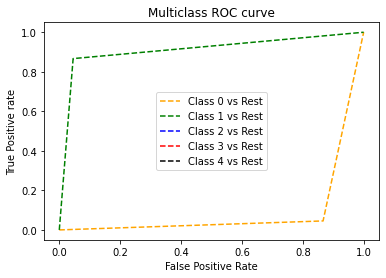

In [94]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [95]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[21  1]
 [ 2 13]]


In [96]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.93      0.87      0.90        15

    accuracy                           0.92        37
   macro avg       0.92      0.91      0.91        37
weighted avg       0.92      0.92      0.92        37



In [97]:
import pickle
filename = './models/IG feature selection/WithoutIP Top9/Binary/KNN/KNN.sav'
pickle.dump(model_KNN, open(filename, 'wb'))
gc.collect()

4364

In [98]:
from sklearn.ensemble import RandomForestClassifier
search_space = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
estimator = RandomForestClassifier()
n_iterations = 50
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator,
    search_spaces=search_space,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    n_iter=n_iterations,
    verbose=0,
    refit=True,
)

  

In [99]:
result_rf = bayes_cv_tuner.fit(X_train, Y_train, callback= [DeltaXStopper(0.0001), 
                                     print_status])


Model #1
Best accuracy so far: 0.952
Best parameters so far: OrderedDict([('max_depth', 143), ('min_samples_split', 8), ('n_estimators', 112)])

Model #2
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('max_depth', 53), ('min_samples_split', 5), ('n_estimators', 552)])

Model #3
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('max_depth', 53), ('min_samples_split', 5), ('n_estimators', 552)])

Model #4
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('max_depth', 53), ('min_samples_split', 5), ('n_estimators', 552)])

Model #5
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('max_depth', 53), ('min_samples_split', 5), ('n_estimators', 552)])

Model #6
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('max_depth', 53), ('min_samples_split', 5), ('n_estimators', 552)])

Model #7
Best accuracy so far: 0.959
Best parameters so far: OrderedDict([('max_depth', 53), ('min_samples_split', 5), ('n_estimators',

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #27
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #28
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #29
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #30
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #31
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])



C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #32
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #33
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #34
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #35
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #36
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #37
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #38
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #40
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #41
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #42
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #43
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #44
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #45
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])

Model #46
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n

C:\Users\hp\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #50
Best accuracy so far: 0.966
Best parameters so far: OrderedDict([('max_depth', 150), ('min_samples_split', 2), ('n_estimators', 634)])



In [100]:
model_RF = RandomForestClassifier(
    n_estimators = result_rf.best_params_['n_estimators'],
     max_depth =  result_rf.best_params_['max_depth'],
       min_samples_split = result_rf.best_params_['min_samples_split']
    )

In [101]:
model_RF.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=150, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=634,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [102]:
# predict probabilities for test set
yhat_probs = model_RF.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [103]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.918919
Precision: 0.940000
Recall: 0.900000
F1 score: 0.912530


In [104]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.826291
[[22  0]
 [ 3 12]]


In [105]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


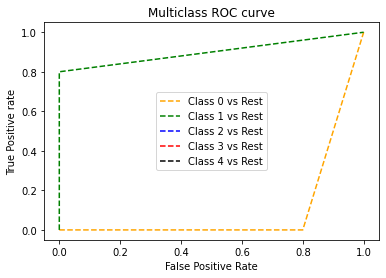

In [106]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [107]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 3 12]]


In [108]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.80      0.89        15

    accuracy                           0.92        37
   macro avg       0.94      0.90      0.91        37
weighted avg       0.93      0.92      0.92        37



In [109]:
import pickle
filename = './models/IG feature selection/WithoutIP Top9/Binary/RF/RF.sav'
pickle.dump(model_RF, open(filename, 'wb'))
gc.collect()

3811